**核支持向量机（kernelized support vector machine**

# 本质是找分割线
SVM（Support Vector Machine）是一种用于分类和回归的监督学习算法，它的核心目标是：在两类数据之间找到一条“最优分界线”，使得分类边界最宽、泛化能力最强。 

它不只关心“能不能分开”，更关心“怎么分得最好”。

SVM 的答案是：找一条 “离两边最近的点都尽可能远”的直线！
也就是让这条线位于两类之间的“中间位置”，形成一个最宽的“隔离带”（margin）。

👉 **这个“隔离带”越宽，模型就越稳定，对新数据的预测就越可靠。**

而那些刚好落在隔离带边缘上的点，就是所谓的“支持向量（Support Vectors）”。

💡 所以 SVM 的名字来源： 

Support：因为这些关键点“支撑”了整个决策边界；

Vector：因为它们是特征空间中的向量（即样本点）；

Machine：机器学习模型。




虽然支
持向量机可以同时用于分类和回归，但我们只会介绍用于分类的情况，它在SVC中实现。
类似的概念也适用于支持向量回归，后者在SVR中实现。


# SVM + 特征扩展 + 3D 可视化
## 第一步：导入所有需要的库


In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn
from sklearn.datasets import make_blobs
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## 第二步： 生成“月亮形”数据

In [55]:
%matplotlib inline  
# 在 Jupyter 中显示图像

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons      # 生成“月亮形”数据
from mpl_toolkits.mplot3d import Axes3D     # 3D 绘图支持
from sklearn.svm import SVC                 # SVM 模型

# 生成 40 个点，像两个月亮，加一点噪声让它更真实
X, y = make_moons(n_samples=40, noise=0.1, random_state=8)

# 查看一下数据长什么样
print("X shape:", X.shape)  # 应该是 (40, 2) —— 40 个点，每个有 2 个特征
print("First 5 points:\n", X[:5])
print("Labels:", y[:10])   # y 是 0 或 1

X shape: (40, 2)
First 5 points:
 [[ 1.71574989 -0.15946635]
 [ 2.03284221  0.42326233]
 [ 1.07908909 -0.5700617 ]
 [ 1.45539154 -0.29953835]
 [-0.89596016  0.50038913]]
Labels: [1 1 1 1 0 1 1 0 1 1]


## 第三步：在二维空间中画出原始数据

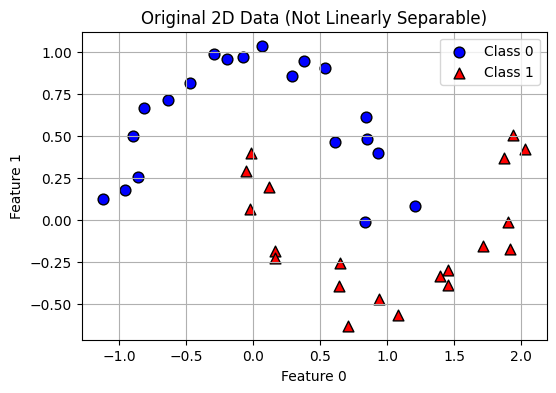

In [56]:
# 在二维空间中画出原始数据
plt.figure(figsize=(6, 4))
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='blue', s=60, label='Class 0', edgecolors='k')
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='red', marker='^', s=60, label='Class 1', edgecolors='k')

plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend()
plt.title("Original 2D Data (Not Linearly Separable)")
plt.grid(True)
plt.show()

效果：你会看到两个交错的“新月”，中间缠绕，任何直线都无法完全分开它们

## 第四步：添加新特征 —— feature1 ** 2
我们现在把原来的两个特征 [x0, x1] 扩展成三个特征 [x0, x1, x1²]

In [57]:
# 创建新特征：x1 的平方
X_new = np.hstack([X, X[:, 1:] ** 2])

# 检查新数据形状
print("X_new shape:", X_new.shape)  # 应该是 (40, 3)
print("First few rows of X_new:\n", X_new[:3])

X_new shape: (40, 3)
First few rows of X_new:
 [[ 1.71574989 -0.15946635  0.02542952]
 [ 2.03284221  0.42326233  0.179151  ]
 [ 1.07908909 -0.5700617   0.32497034]]


👉 注意第三列是第二列的平方！

### 特征工程补充

```
X_new = np.hstack([X, X[:, 1:] ** 2])  # 添加 feature1 的平方
```
原始特征：[x0, x1]

新特征：[x0, x1, x1²]

在三维空间中，点被“拉高”或“压低”，变得可以被一个平面分开

✅ 然后我们在 3D 中训练线性 SVM，再把边界投影回 2D。

💡 这就是 “核技巧”的本质：通过特征变换，让原本不可分的问题变成可分。

## 第五步：把数据画在 3D 空间中

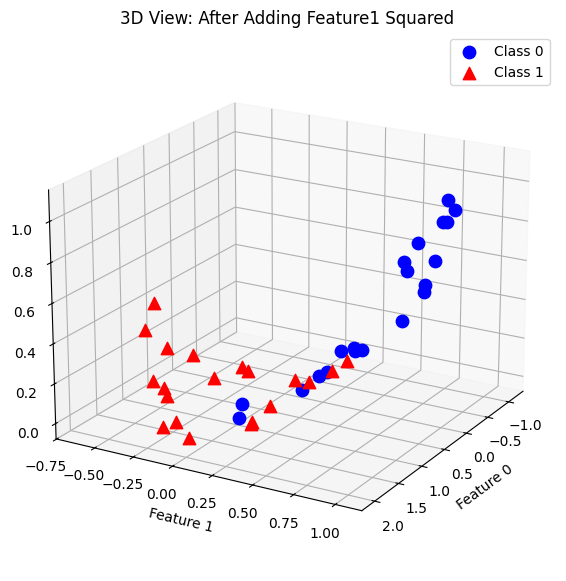

In [58]:
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')  # 创建 3D 坐标系

# 分类绘制
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2],
           c='blue', s=80, label='Class 0', depthshade=False)

ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2],
           c='red', marker='^', s=80, label='Class 1', depthshade=False)

# 设置坐标轴标签
ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")
ax.set_zlabel("Feature 1 ** 2")

# 调整视角，看得更清楚
ax.view_init(elev=20, azim=30)

# 显示图例
plt.legend()
plt.title("3D View: After Adding Feature1 Squared")
plt.show()

🎯 效果：你会发现红色和蓝色的点现在在 z 轴方向上分开了！
➡️ 它们现在已经可以用一个 平面 分开了！

这就是“核技巧”的思想：把数据映射到更高维空间，让它变得线性可分

##  第六步：训练 SVM 模型 



In [59]:
# 使用线性 SVM（因为我们已经做了特征工程）
svm = SVC(kernel='linear', C=1000)  # C 很大表示不允许误分类（用于教学）
svm.fit(X_new, y)

,C,1000
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


✅ kernel='linear' 表示我们只用线性超平面分割 
## 第七步：画出决策平面（3D 中的平面）
我们来画出 SVM 决策边界（也就是分类平面）：

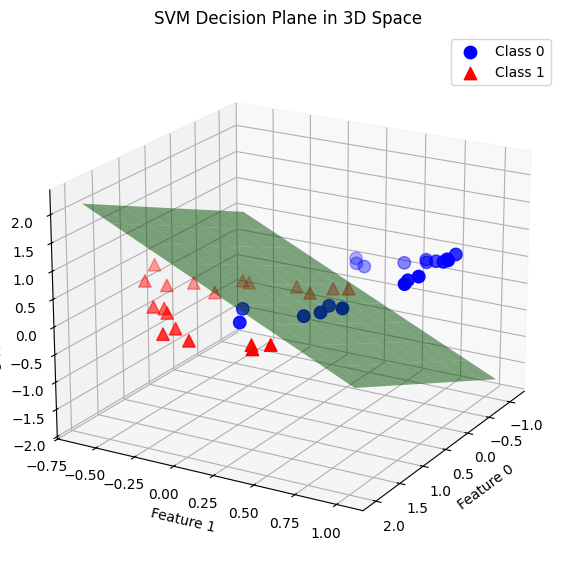

In [60]:
# 创建网格点用于画平面
xx, yy = np.meshgrid(np.linspace(X_new[:, 0].min(), X_new[:, 0].max(), 10),
                     np.linspace(X_new[:, 1].min(), X_new[:, 1].max(), 10))
zz = (-svm.intercept_[0] - svm.coef_[0][0] * xx - svm.coef_[0][1] * yy) / svm.coef_[0][2]

# 画图
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

# 重新画点
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='blue', s=80, label='Class 0')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='red', marker='^', s=80, label='Class 1')

# 画决策平面
ax.plot_surface(xx, yy, zz, alpha=0.5, color='green', linewidth=0)

ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")
ax.set_zlabel("Feature 1 ** 2")
ax.view_init(elev=20, azim=30)
plt.legend()
plt.title("SVM Decision Plane in 3D Space")
plt.show()

### 为什么没有完全分开
-- 因为我们前面加了噪音

--还有虽然 C=1000 是一个很大的值（表示对误分类惩罚很重），
但它 不能保证完全无误分类

机器学习的目标不是“完全正确”，而是 在真实世界中尽可能好地泛化。 


**C 是 正则化参数**，控制模型对误分类的容忍度。

C 越大 → 模型越“严格” → 不允许点进入边界内（软间隔越硬）



我们来看看完美的分开：

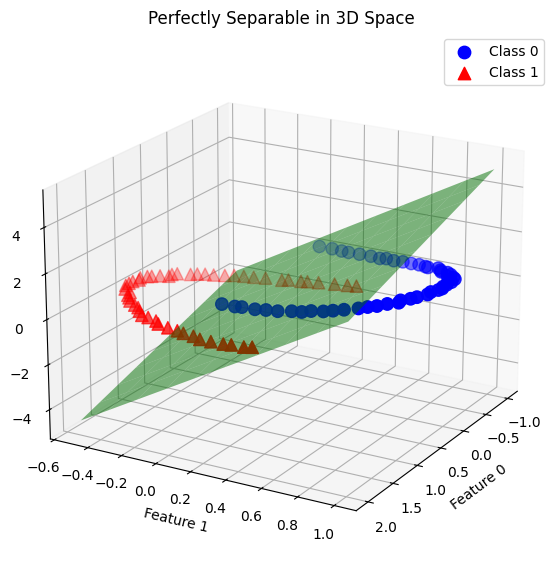

In [61]:
# 生成干净数据（低噪音）
X, y = make_moons(n_samples=100, noise=0.01, random_state=8)

# 添加新特征
X_new = np.hstack([X, X[:, 1:] ** 2])

# 训练 SVM（高惩罚）
svm = SVC(kernel='linear', C=1e6)
svm.fit(X_new, y)

# 画图
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='blue', s=80, label='Class 0')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='red', marker='^', s=80, label='Class 1')

# 决策平面
xx, yy = np.meshgrid(np.linspace(X_new[:, 0].min(), X_new[:, 0].max(), 10),
                     np.linspace(X_new[:, 1].min(), X_new[:, 1].max(), 10))
zz = (-svm.intercept_[0] - svm.coef_[0][0] * xx - svm.coef_[0][1] * yy) / svm.coef_[0][2]
ax.plot_surface(xx, yy, zz, alpha=0.5, color='green')

ax.set_xlabel("Feature 0"); ax.set_ylabel("Feature 1"); ax.set_zlabel("Feature 1 ** 2")
ax.view_init(elev=20, azim=30)
plt.legend()
plt.title("Perfectly Separable in 3D Space")
plt.show()

## 第八步：把 3D 决策平面投影回原始的二维空间、
### SVM做法
由于数据是不可分的，这个图一定也是不可分的

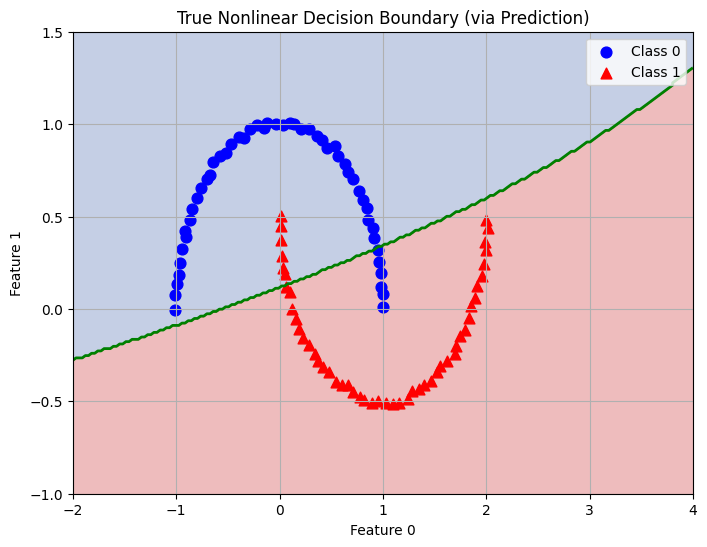

In [62]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.svm import SVC

# 1. 生成数据
X, y = make_moons(n_samples=100, noise=0.01, random_state=8)

# 2. 添加新特征：feature1 的平方
X_new = np.hstack([X, X[:, 1:] ** 2])

# 3. 训练 SVM
svm = SVC(kernel='linear', C=1e6)
svm.fit(X_new, y)

# 4. 在 2D 网格上预测（这才是正确的做法）
xx, yy = np.meshgrid(np.linspace(-2, 4, 200),
                     np.linspace(-1, 1.5, 200))
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_points_new = np.hstack([grid_points, grid_points[:, 1:] ** 2])
Z = svm.predict(grid_points_new).reshape(xx.shape)

# 5. 画图
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu_r)
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='blue', s=60, label='Class 0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='red', marker='^', s=60, label='Class 1')
plt.contour(xx, yy, Z, levels=[0.5], colors='green', linewidths=2)

plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title("True Nonlinear Decision Boundary (via Prediction)")
plt.legend()
plt.grid(True)
plt.show()

## RBF做法（完美分开）
### rbf是什么
rbf 是 "Radial Basis Function" 的缩写

它相当于自动把数据映射到无限维空间

然后用线性模型分类

最终在原始空间中表现为 平滑的非线性边界

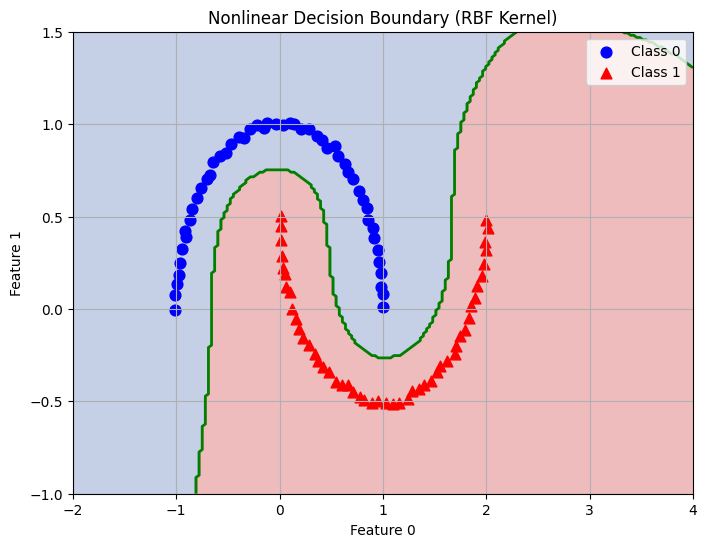

In [63]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.svm import SVC

# 1. 生成数据
X, y = make_moons(n_samples=100, noise=0.01, random_state=8)

# 2. 添加新特征：feature1 的平方
X_new = np.hstack([X, X[:, 1:] ** 2])

# 3. 使用 RBF 核（非线性）
svm = SVC(kernel='rbf', C=1e6, gamma='scale')  # 👈 改为 rbf
svm.fit(X_new, y)

# 4. 在网格上预测
xx, yy = np.meshgrid(np.linspace(-2, 4, 200),
                     np.linspace(-1, 1.5, 200))
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_points_new = np.hstack([grid_points, grid_points[:, 1:] ** 2])
Z = svm.predict(grid_points_new).reshape(xx.shape)

# 5. 画图
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu_r)
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='blue', s=60, label='Class 0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='red', marker='^', s=60, label='Class 1')
plt.contour(xx, yy, Z, levels=[0.5], colors='green', linewidths=2)

plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title("Nonlinear Decision Boundary (RBF Kernel)")
plt.legend()
plt.grid(True)
plt.show()

# 如果数据分不开怎么办

```python
X, y = make_moons(n_samples=100, noise=0.01)
```

- 用 `linear SVM` → 只能画一条直线
- 结果：无法完美分开

👉 所以我们要让模型能画曲线！

## 一、特征工程
比如：
```python
X_new = np.hstack([X, X[:, 0]**2, X[:, 1]**2, X[:, 0]*X[:, 1]])
```
- 把原始特征变成高维特征
- 在新空间中，数据可能变得线性可分
- 然后用线性 SVM 分类

✅ 优点：直观、容易理解  

❌ 缺点：
- 要自己想加什么特征？
- 特征太多 → 计算量爆炸（比如 100 维 → 5000 个交互项）
- 很难覆盖所有可能性


## 二、核技巧（kernel trick）

核技巧的本质是：**我不显式地构造高维特征，但我能“假装”我已经在高维空间里了！**

它的原理是**直接计算扩展特征表示中数据点之间的距离（更准确地说
是内积），而不用实际对扩展进行计算**


### 内积（Dot Product）是什么？

两个向量 $ \mathbf{a} $ 和 $ \mathbf{b} $ 的内积是：

$$
\mathbf{a} \cdot \mathbf{b} = a_1 b_1 + a_2 b_2 + \dots
$$

在机器学习中，SVM 的训练过程其实只依赖于 **样本之间的内积**，而不是具体的特征值。

## 将数据映射到更高维空间的方法

### 多项式核

一种是**多项式核**，在一定阶数内计算原始特征所有可能的多项式（比如feature1 ** 2 * feature2 ** 5）；

### 高斯核

另一种是**径向基函数**（radial basis function，RBF）核，也叫**高斯核**。

高斯核有点难以解释，因为它对应**无限维的特征空间**。

一种对高斯核的解释是它考虑所有阶数的所有可能的多项
式，但**阶数越高，特征的重要性越小**。

**公式**：
$$
K(x_i, x_j) = \exp\left(-\gamma \|x_i - x_j\|^2\right)
$$

- `γ` 控制“影响范围”
- 距离越近，相似度越高（接近 1）
- 距离越远，相似度越低（接近 0）

> 🌟 优点：能处理任意形状的边界，非常灵活  
> ⚠️ 缺点：难解释，参数敏感

这里x1和x2是数据点，‖x1- x2 ‖表示欧氏距离，γ（gamma）是控制高斯核宽度的参数。


# SVM调参
## 为什么要调参
你已经知道：

使用 rbf 核可以让 SVM 学习复杂的非线性边界

但如果不小心设置参数，可能会出现：

❌ 过拟合（模型太复杂，记住噪声）

❌ 欠拟合（模型太简单，连趋势都学不会）

所以我们必须学会控制它的“灵活性”。

图2-41 是支持向量机对一个二维二分类数据集的训练结果。决策边界用黑色表示，支持向
量是尺寸较大的点。

下列代码将在forge数据集上训练SVM并创建此图
## RBF核SVM给出的决策边界和支持向量

Text(0, 0.5, 'Feature 1')

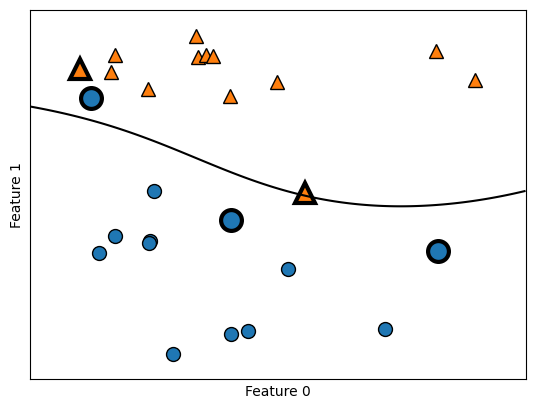

In [64]:
from sklearn.svm import SVC 
X, y = mglearn.tools.make_handcrafted_dataset() 
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y) 
mglearn.plots.plot_2d_separator(svm, X, eps=.5) 
mglearn.discrete_scatter(X[:, 0], X[:, 1], y) 
# 画出支持向量 
sv = svm.support_vectors_ 
# 支持向量的类别标签由dual_coef_的正负号给出 
sv_labels = svm.dual_coef_.ravel() > 0 
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3) 
plt.xlabel("Feature 0") 
plt.ylabel("Feature 1")


在这个例子中，SVM给出了非常平滑且非线性（不是直线）的边界。这里我们调节了两
个参数：C参数和gamma参数

**gamma 参数**是上一节给出的公式中的参数，用于控制高斯核的宽度。它决定了点与点之间
“靠近”是指多大的距离。

**C参数是正则化参数**，与线性模型中用到的类似。

它限制每个点
的重要性（或者更确切地说，每个点的dual_coef_）。


我们来看一下，改变这些参数时会发生什么（图2-42）
## 设置不同的C和gamma参数对应的决策边界和支持向量

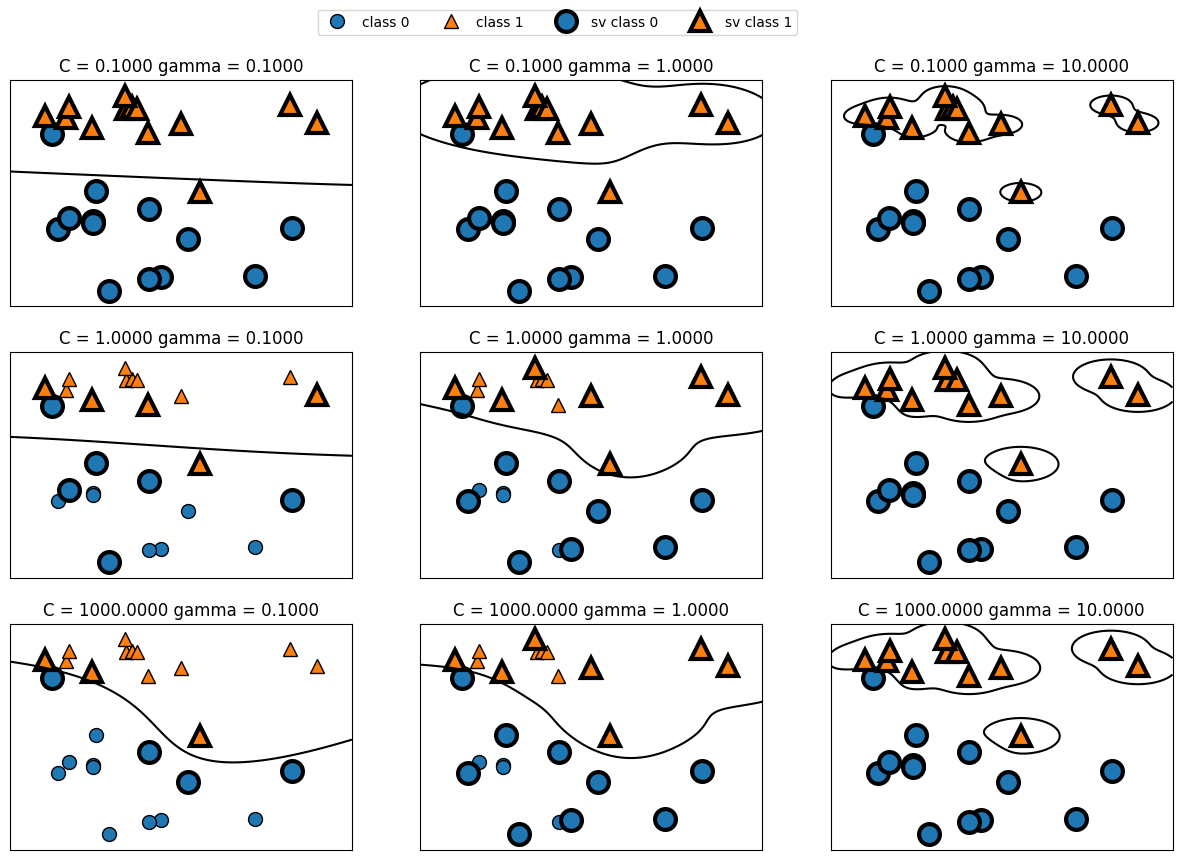

In [65]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10)) 
for ax, C in zip(axes, [-1, 0, 3]): 
    for a, gamma in zip(ax, range(-1, 2)): 
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a) 
axes[0, 0].legend(["class 0", "class 1", "sv class 0", "sv class 1"], 
                  ncol=4, loc=(.9, 1.2))

## c 和 gamma的区别

| 参数 | 控制什么？ | 类比 |
|------|------------|------|
| `C` | 正则化强度 | “对错误的容忍度” |
| `gamma` | RBF 核的宽度 | “每个点的影响范围” |

-----------


| 参数 | 影响 | 图形表现 |
|------|------|----------|
| `C` ↑ | 更严格，不允许错误 | 决策边界更紧贴数据，支持向量更多 |
| `C` ↓ | 更宽容，允许错误 | 决策边界更平滑，支持向量更少 |
| `gamma` ↑ | 局部影响增强 | 边界更复杂，可能出现“小岛” |
| `gamma` ↓ | 全局影响增强 | 边界更平滑，像直线 |


-------------

**C**

> ✅ 推荐范围：`0.1 ~ 100`，通常从 `1` 开始尝试
- `C` 越大 → 越不能容忍误分类
- `C` 越小 → 允许更多错误，更平滑

-------------

**gamma**

> ✅ 推荐范围：`0.001 ~ 10`，常用 `'scale'`（自动计算）
- `gamma` 越大 → 只有非常近的点才被认为是“相似”的 → 局部影响
- `gamma` 越小 → 更多远处的点也被考虑 → 全局影响



## 将RBF核SVM应用到乳腺癌数据集上
默认情况下，C=1，gamma=1/n_features：

In [68]:
from sklearn.datasets import load_breast_cancer
X_train, X_test, y_train, y_test = train_test_split( 
    cancer.data, cancer.target, random_state=0) 
svc = SVC() 
svc.fit(X_train, y_train) 
print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train))) 
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 0.90
Accuracy on test set: 0.94


这个模型在训练集上的分数十分完美，但在测试集上的精度只有63%，(可能数据更新了吧)存在相当严重的过
拟合。

虽然SVM的表现通常都很好，但它对参数的设定和数据的缩放非常敏感。特别地，
它要求所有特征有相似的变化范围。

我们来看一下每个特征的最小值和最大值，它们绘制
在对数坐标上（图2-43）：
### 乳腺癌数据集的特征范围（注意y轴的对数坐标）

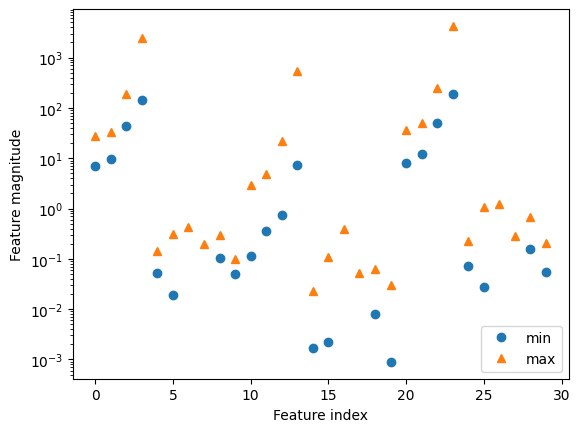

In [69]:
plt.plot(X_train.min(axis=0), 'o', label="min") 
plt.plot(X_train.max(axis=0), '^', label="max") 
plt.legend(loc=4) 
plt.xlabel("Feature index") 
plt.ylabel("Feature magnitude") 
plt.yscale("log")

从这张图中，我们可以确定乳腺癌数据集的特征具有完全不同的数量级。这对其他模型来
说（比如线性模型）可能是小问题，但对核SVM却有极大影响。

我们来研究处理这个问
题的几种方法。

# 为SVM预处理数据
解决这个问题的一种方法就是**对每个特征进行缩放**，使其大致都位于同一范围。
核SVM
常用的缩放方法就是将所有特征缩放到0和1之间。

我们将在第3章学习如何使用
MinMaxScaler 预处理方法来做到这一点，到时会给出更多细节。现在我们来“人工”做到
这一点：

In [71]:
# 计算训练集中每个特征的最小值 
min_on_training = X_train.min(axis=0) 
# 计算训练集中每个特征的范围（最大值-最小值） 
range_on_training = (X_train - min_on_training).max(axis=0) 
# 减去最小值，然后除以范围 
# 这样每个特征都是min=0和max=1 
X_train_scaled = (X_train - min_on_training) / range_on_training 
print("Minimum for each feature\n{}".format(X_train_scaled.min(axis=0))) 
print("Maximum for each feature\n {}".format(X_train_scaled.max(axis=0)))

Minimum for each feature
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Maximum for each feature
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


没看懂是吧嘻嘻

## 特征缩放（Feature Scaling）补充

目标：把所有特征都缩放到相同的范围（通常是 [0, 1] 或 [-1, 1]）

### 归一化（Min-Max Scaling）
公式：
$$
x_{\text{scaled}} = \frac{x - x_{\min}}{x_{\max} - x_{\min}}
$$

这样每个特征都会变成：
- 最小值 → 0
- 最大值 → 1
- 其他值 → 在 `[0, 1]` 之间

###  为什么需要这个操作？

1. **让模型训练更稳定**
- SVM、KNN、神经网络等对特征尺度敏感
- 如果一个特征很大，它会在损失函数中占主导地位

2. **加快收敛速度**
- 梯度下降时，如果特征尺度差异大，优化路径会“之字形”走很久
- 缩放后，优化更快

 3. **避免数值问题**
- 很大的数可能导致浮点溢出或计算不稳定



In [72]:
# 利用训练集的最小值和范围对测试集做相同的变换（详见第3章） 
X_test_scaled = (X_test - min_on_training) / range_on_training

In [73]:
svc = SVC() 
svc.fit(X_train_scaled, y_train) 
print("Accuracy on training set: {:.3f}".format( 
    svc.score(X_train_scaled, y_train))) 
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.984
Accuracy on test set: 0.972


数据缩放的作用很大！实际上模型现在处于欠拟合的状态，因为训练集和测试集的性能非
常接近，但还没有接近100%的精度。

从这里开始，我们可以尝试增大C或gamma来拟合
更为复杂的模型。例如：

In [75]:
svc = SVC(C=1000) 
svc.fit(X_train_scaled, y_train) 
print("Accuracy on training set: {:.3f}".format( 
    svc.score(X_train_scaled, y_train))) 
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.958


在这个例子中，增大C可以显著改进模型，得到97.2%的精度。
# 优缺点和参数
核支持向量机是非常强大的模型，在各种数据集上的表现都很好

## 优点：SVM 是个“聪明又全能”的模型！

- **很强大**：不管数据是简单还是复杂，SVM 都能表现不错。
- **适应性强**：无论是特征少（低维）还是特征多（高维），它都能搞定。
- **决策边界灵活**：可以用“核技巧”画出弯弯曲曲的线，分得更准。
- **适合小到中等规模数据**：比如几千个样本，它跑得又快又好。

> 💡 尤其适合：所有特征单位差不多（比如都是数字大小）、范围也接近的情况。

---------


## 缺点：它也有“小脾气”，需要你细心照顾

1. **对样本数量敏感**  
   - 如果数据只有几千个 → 没问题  
   - 但如果达到 10 万甚至更多 → 可能会变慢、吃内存多，运行起来有点“卡”

2. **预处理很重要**  
   - 数据要标准化（比如把每个特征缩放到 0~1 或均值为 0），否则 SVM 容易“偏心”某个特征。
   - 所以不能随便丢数据进去，得先“打扮整齐”。

3. **调参麻烦**  
   - 要选好核函数（比如 RBF、线性等）
   - 还要调参数 C 和 gamma，它们像“魔法开关”，影响模型复杂度
   - 不小心调错，就可能过拟合或欠拟合

4. **黑箱模型**  
   - 它预测很准，但很难解释“为什么这么预测”
   - 对非专业人士来说，就像一个“神秘盒子”——输入输出清楚，中间过程看不懂

> 🌱 所以现在很多应用用随机森林、XGBoost 等树模型，因为它们更简单、好理解、也不太挑数据。

------

## 重要参数

| 参数 | 作用 | 温柔解释 |
|------|------|----------|
| **C（正则化参数）** | 控制模型对错误的容忍程度 | C 大 → 想要分得更准，但容易过拟合；C 小 → 容易出错，但更稳 |
| **gamma（RBF 核参数）** | 控制“高斯核”的宽度 | gamma 大 → 决策边界更复杂，像“贴身紧贴”数据；gamma 小 → 更平滑 |

> 🔗 注意：C 和 gamma 是“搭档”，通常要一起调！它们都影响模型复杂度。


